/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

<ipython-input-1-531b634cdbb5>:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([1, 2, 3, 4, 5], color="grey", size=7)


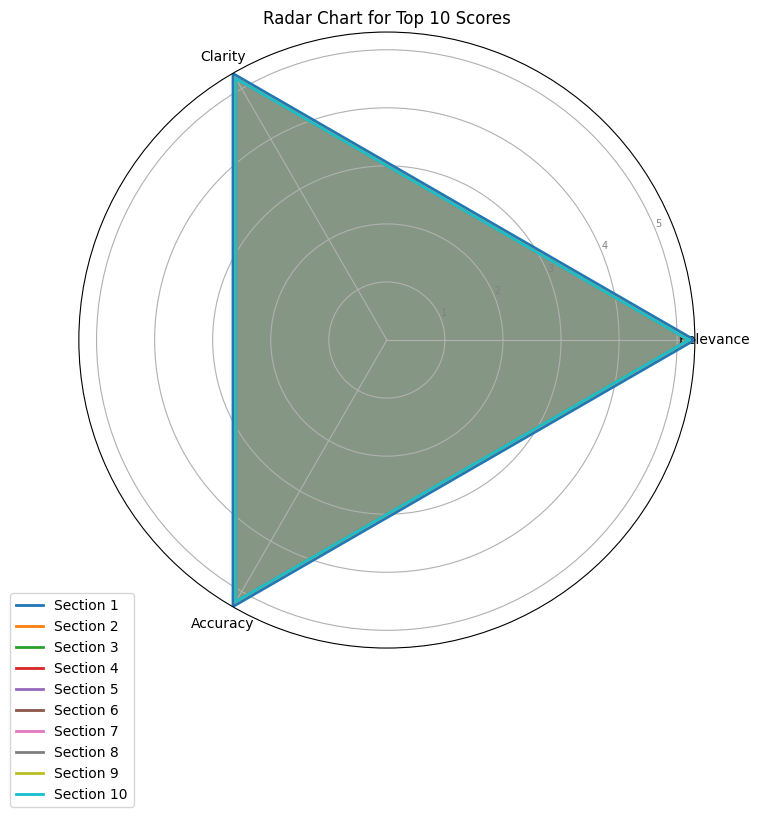

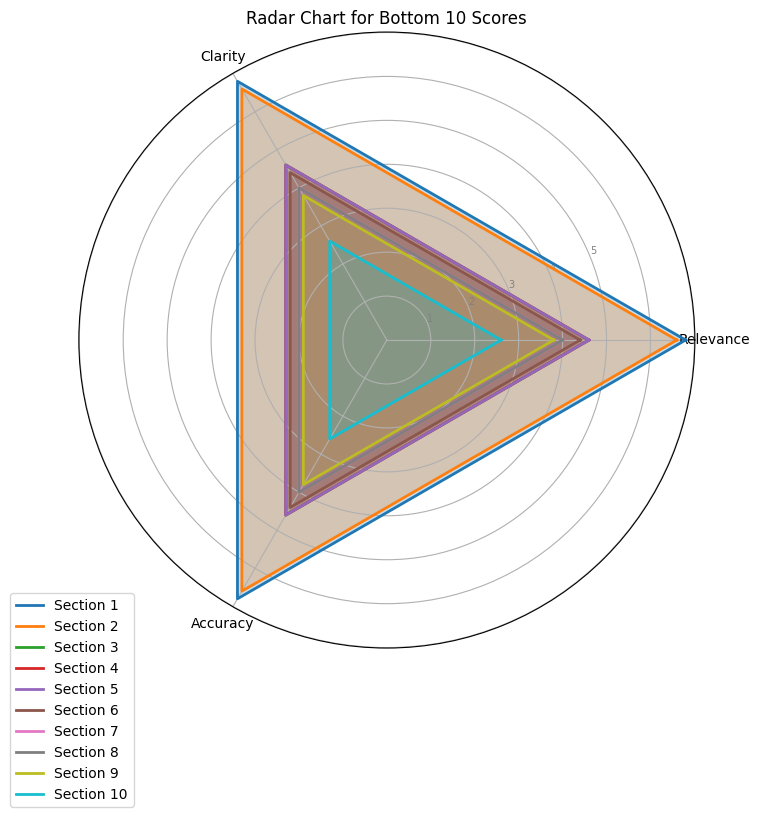

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from transformers import pipeline

# Function to tidy up text by fixing common encoding issues and formatting
def clean_text(text):
    text = text.replace("â", "'").replace("â", "-").replace("â", '"').replace("â", '"')
    text = text.replace("\\n", "\n").replace("Ã©", "é").replace("â¦", "…")
    text = re.sub(r'{\"generated_text\": \"(.*?)\"}', r'\1', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Load and clean LLaMA-generated questions
with open('llama-test-dataset-singleline-responses-3.txt', 'r', encoding='ISO-8859-1') as file:
    questions = [clean_text(q.strip()) for q in file.readlines() if q.strip()]

# Load and clean key sections from scientific content
with open('scientific_facts_output.txt', 'r', encoding='ISO-8859-1') as file:
    key_sections = [clean_text(section.strip()) for section in file.readlines() if section.strip()]

# Load a pre-trained language model for classifying text
llm_evaluator = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

# Function to evaluate content against a rubric and score it
def evaluate_content_with_rubric(question, section):
    rubric = {"Relevance": 0.4, "Clarity": 0.3, "Accuracy": 0.3}

    scores = {}
    relevance_prompt = f"Evaluate how relevant this response is to the question. Score it between 1 and 5.\n\nQuestion: {question}\n\nResponse: {section}\n\n"
    relevance_response = llm_evaluator(relevance_prompt)
    scores["Relevance"] = map_label_to_score(relevance_response[0]['label'])

    clarity_prompt = f"Evaluate how clearly this response is written. Score it between 1 and 5.\n\nResponse: {section}\n\n"
    clarity_response = llm_evaluator(clarity_prompt)
    scores["Clarity"] = map_label_to_score(clarity_response[0]['label'])

    accuracy_prompt = f"Evaluate the accuracy of this response. Score it between 1 and 5.\n\nQuestion: {question}\n\nResponse: {section}\n\n"
    accuracy_response = llm_evaluator(accuracy_prompt)
    scores["Accuracy"] = map_label_to_score(accuracy_response[0]['label'])

    length_penalty = min(len(question), len(section)) / 1000
    length_penalty = min(1.0, length_penalty)

    weighted_score = sum(rubric[aspect] * scores[aspect] for aspect in rubric) - length_penalty
    final_score = max(1, min(10, round(weighted_score, 1)))
    return final_score

# Convert LLM sentiment labels into numeric scores for easier comparison
def map_label_to_score(label):
    if label == "POSITIVE":
        return 5
    elif label == "NEGATIVE":
        return 1
    else:
        return 3

# Meta-judging function to handle scoring discrepancies
def meta_judge(score1, score2):
    if abs(score1 - score2) < 0.5:
        meta_score = (score1 + score2) / 2
    else:
        meta_score = max(score1, score2)

    meta_score += np.random.uniform(-0.3, 0.3)
    meta_score = max(1, min(10, round(meta_score, 1)))
    return meta_score

# Evaluate and score content
llm_scores = []
for i, question in enumerate(questions[:10]):
    for j, section in enumerate(key_sections[:10]):
        score1 = evaluate_content_with_rubric(question, section)
        score2 = evaluate_content_with_rubric(question, section)
        final_score = meta_judge(score1, score2)
        llm_scores.append((final_score, question, section))

llm_scores = sorted(llm_scores, key=lambda x: x[0], reverse=True)

# Write the final sorted scores to an output file
with open('llm_content_evaluation_scores_output.txt', 'w', encoding='utf-8') as f:
    f.write("Content Evaluation Scores (1-10):\n")
    for score, question, section in llm_scores:
        f.write(f"Question:\n{question}\n\n")
        f.write(f"Section:\n{section}\n\n")
        f.write(f"Score: {score}/10\n")
        f.write("="*80 + "\n\n")

# Function to parse the file and extract scores
def parse_scores(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    matches = re.findall(r'Score: (\d+\.\d)/10', content)
    sections = re.findall(r'Section:\n(.+?)\n\n', content, re.DOTALL)
    questions = re.findall(r'Question:\n(.+?)\n\n', content, re.DOTALL)

    scores = [float(score) for score in matches]
    return list(zip(scores, questions, sections))

# Function to extract radar chart data
def extract_radar_data(scores_list):
    radar_data = []
    for score, question, section in scores_list:
        relevance = clarity = accuracy = score
        radar_data.append([relevance, clarity, accuracy])
    return radar_data

# Parse the file and extract scores
file_path = 'llm_content_evaluation_scores_output.txt'
llm_scores = parse_scores(file_path)

# Sort and select top and bottom scores
sorted_llm_scores = sorted(llm_scores, key=lambda x: x[0], reverse=True)
top_ten_scores = sorted_llm_scores[:10]
bottom_ten_scores = sorted_llm_scores[-10:]

categories = ['Relevance', 'Clarity', 'Accuracy']
num_categories = len(categories)

top_radar_data = extract_radar_data(top_ten_scores)
bottom_radar_data = extract_radar_data(bottom_ten_scores)

# Function to create radar chart
def plot_radar_chart(radar_data, title):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, data in enumerate(radar_data):
        values = data + data[:1]
        angles = [n / float(num_categories) * 2 * pi for n in range(num_categories)]
        angles += angles[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Section {i+1}')
        ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticklabels([1, 2, 3, 4, 5], color="grey", size=7)
    ax.set_title(title)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Plot radar charts for top 10 and bottom 10 sections
plot_radar_chart(top_radar_data, "Radar Chart for Top 10 Scores")
plot_radar_chart(bottom_radar_data, "Radar Chart for Bottom 10 Scores")
